In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import deepchem as dc
from datasail.sail import datasail
import json

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

import deepchem as dc

SEED = 42
np.random.seed(SEED)

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/kirill/miniconda3/envs/ml/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/kirill/miniconda3/envs/ml/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped 

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

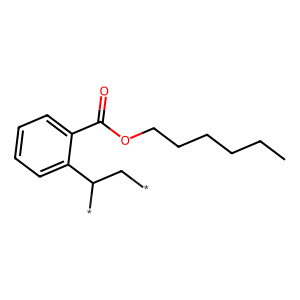

In [3]:
mol = Chem.MolFromSmiles(train_data['SMILES'][0])
Chem.SanitizeMol(mol)
Draw.MolToImage(mol)

In [4]:
train_data.describe()

,id,Tg,FFV,Tc,Density,Rg
count,7.973000e+03,511.000000,7030.000000,737.000000,613.000000,614.000000
mean,1.080050e+09,96.452314,0.367212,0.256334,0.985484,16.419787
std,6.218241e+08,111.228279,0.029609,0.089538,0.146189,4.608640
min,8.781700e+04,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,5.376641e+08,13.674509,0.349549,0.186000,0.890243,12.540328
50%,1.079079e+09,74.040183,0.364264,0.236000,0.948193,15.052194
75%,1.621708e+09,161.147595,0.380790,0.330500,1.062096,20.411067
max,2.147438e+09,472.250000,0.777097,0.524000,1.840999,34.672906


In [5]:
class Config:
    TARGET_LIST = ['FFV', 'Tg', 'Tc', 'Density', 'Rg']
    
    def get_canonical_smiles(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        flag = Chem.SanitizeMol(mol, catchErrors=True)
        
        if flag != Chem.rdmolops.SanitizeFlags.SANITIZE_NONE:
            Chem.SanitizeMol(mol, sanitizeOps=Chem.rdmolops.SanitizeFlags.SANITIZE_ALL ^ flag)

        smiles = Chem.MolToSmiles(mol, canonical=True)
        
        return smiles
        
    def vectorize_smiles(self, smiles: str):
        smiles = self.get_canonical_smiles(smiles)
        mol = Chem.MolFromSmiles(smiles)
        
        descriptors = {
            'MW': Descriptors.MolWt(mol),
            'HBA': Descriptors.NOCount(mol),
            'HBD': Descriptors.NHOHCount(mol),
            'LogP': Descriptors.MolLogP(mol),
            'TPSA': Descriptors.TPSA(mol),
            'EtherCount': Chem.Fragments.fr_ether(mol),
            'EsterCount': Chem.Fragments.fr_ester(mol),
            'AmideCount': Chem.Fragments.fr_amide(mol),
            'AromaticRingCount': Chem.rdMolDescriptors.CalcNumAromaticRings(mol),
            'BertzCT': Descriptors.BertzCT(mol),
            'BalabanJ': Descriptors.BalabanJ(mol)
        }
        morgen = AllChem.GetMorganGenerator(radius=2, fpSize=2048)
        fp = morgen.GetFingerprint(mol)
        fp_feat = {idx: int(bit) for idx, bit in enumerate(fp)} 
        descriptors.update(fp_feat)
        return descriptors

config = Config()

In [6]:
train_data.duplicated(subset='SMILES').any()

False

In [7]:
feature_df = pd.json_normalize(train_data['SMILES'].apply(config.vectorize_smiles))

In [8]:
data = pd.concat([train_data, feature_df.reset_index(drop=True)], axis=1)

# DeepChem test

In [14]:
featurizer = dc.feat.MordredDescriptors(ignore_3D=True)
train_data['desc'] = train_data['SMILES'].apply(featurizer)

In [9]:
def remove_asterisk(smiles):
    smiles = smiles.replace('*', '')
    smiles = smiles.replace('(*)', '')
    smiles = smiles.replace('()', '')

    return smiles

In [10]:
train_data = pd.read_pickle('data/descriptors_calc.pkl')
train_data['corrected_smiles'] = train_data['SMILES'].apply(remove_asterisk)

In [11]:
train_ffv = train_data[train_data['FFV'].notnull()][['id', 'SMILES', 'corrected_smiles', 'FFV', 'desc']]
train_tg = train_data[train_data['Tg'].notnull()][['id', 'SMILES', 'corrected_smiles', 'Tg', 'desc']]
train_tc = train_data[train_data['Tc'].notnull()][['id', 'SMILES', 'corrected_smiles', 'Tc', 'desc']]
train_density = train_data[train_data['Density'].notnull()][['id', 'SMILES', 'corrected_smiles', 'Density', 'desc']]
train_rg = train_data[train_data['Rg'].notnull()][['id', 'SMILES', 'corrected_smiles', 'Rg', 'desc']]

In [12]:
X = np.vstack(train_ffv['desc'])
y = np.array(train_ffv['FFV'])

In [13]:
nan_mask = np.isnan(X)
rows_with_nan = np.where(nan_mask.any(axis=1))[0]
cols_with_nan = np.where(nan_mask.any(axis=0))[0]


In [14]:
cols_with_nan

array([1208, 1209, 1210, 1211, 1212, 1221, 1222, 1223, 1224, 1229, 1230,
       1231, 1232, 1237, 1238, 1239, 1240, 1242, 1243, 1244, 1245, 1246,
       1247, 1250, 1251, 1252, 1305, 1411, 1412])

In [15]:
X_clean = X[:, ~cols_with_nan]

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

In [67]:
def _store_metrics(results_dict, model_name, y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    pearson, _ = pearsonr(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    results_dict[model_name]['rmse'].append(rmse)
    results_dict[model_name]['pearsonr'].append(pearson)
    results_dict[model_name]['mae'].append(mae)

results = {
        'SVR': {'rmse': [], 'pearsonr': [], 'mae': []},
        'XGB': {'rmse': [], 'pearsonr': [], 'mae': []},
        'LinearRegression': {'rmse': [], 'pearsonr': [], 'mae': []},
        'MLP': {'rmse': [], 'pearsonr': [], 'mae': []},
        'RandomForest': {'rmse': [], 'pearsonr': [], 'mae': []},
        'ExtraTrees': {'rmse': [], 'pearsonr': [], 'mae': []},
        'AdaBoost': {'rmse': [], 'pearsonr': [], 'mae': []},
    }
    
for fold in range(5):
    print(f"Fold {fold+1}/5")
    
    split_dict = e_splits['C1e'][fold]
    train_index, val_index, test_index = [], [], []
    
    for index, idx in enumerate(train_ffv['id']):
        split = split_dict.get(idx)
        if split == 'train':
            train_index.append(index)
        elif split == 'val':
            val_index.append(index)

    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_val)
    _store_metrics(results, 'SVR', y_val, y_pred_svr)

    xgb_model = xgb.XGBRegressor(n_estimators=300, objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_val)
    _store_metrics(results, 'XGB', y_val, y_pred_xgb)

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_val)
    _store_metrics(results, 'LinearRegression', y_val, y_pred_lr)

    mlp_model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
    mlp_model.fit(X_train, y_train)
    y_pred_mlp = mlp_model.predict(X_val)
    _store_metrics(results, 'MLP', y_val, y_pred_mlp)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_val)
    _store_metrics(results, 'RandomForest', y_val, y_pred_rf)

    et_model = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    et_model.fit(X_train, y_train)
    y_pred_et = et_model.predict(X_val)
    _store_metrics(results, 'ExtraTrees', y_val, y_pred_et)

    ab_model = AdaBoostRegressor(n_estimators=100, random_state=42)
    ab_model.fit(X_train, y_train)
    y_pred_ab = ab_model.predict(X_val)
    _store_metrics(results, 'AdaBoost', y_val, y_pred_ab)

print("\n==== Cross-Validation Results ====\n")
for model in results:
    mean_rmse = np.mean(results[model]['rmse'])
    std_rmse = np.std(results[model]['rmse'])
    mean_pearsonr = np.mean(results[model]['pearsonr'])
    std_pearsonr = np.std(results[model]['pearsonr'])
    mean_mae = np.mean(results[model]['mae'])
    std_mae = np.std(results[model]['mae'])
    
    print(f"{model} Model:")
    print(f"  RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
    print(f"  Pearson r: {mean_pearsonr:.4f} ± {std_pearsonr:.4f}")
    print(f"  MAE: {mean_mae:.4f} ± {std_mae:.4f}")
    print()


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

==== Cross-Validation Results ====

SVR Model:
  RMSE: 0.0565 ± 0.0020
  Pearson r: -0.0408 ± 0.0310
  MAE: 0.0481 ± 0.0012

XGB Model:
  RMSE: 0.0409 ± 0.0021
  Pearson r: 0.1198 ± 0.0508
  MAE: 0.0285 ± 0.0012

LinearRegression Model:
  RMSE: 0.0387 ± 0.0024
  Pearson r: 0.0636 ± 0.0494
  MAE: 0.0276 ± 0.0010

MLP Model:
  RMSE: 0.0772 ± 0.0084
  Pearson r: 0.0558 ± 0.0062
  MAE: 0.0398 ± 0.0021

RandomForest Model:
  RMSE: 0.0394 ± 0.0020
  Pearson r: 0.1386 ± 0.0550
  MAE: 0.0274 ± 0.0009

ExtraTrees Model:
  RMSE: 0.0387 ± 0.0020
  Pearson r: 0.1162 ± 0.0800
  MAE: 0.0274 ± 0.0008

AdaBoost Model:
  RMSE: 0.0466 ± 0.0003
  Pearson r: 0.0627 ± 0.0230
  MAE: 0.0375 ± 0.0017



In [10]:
params = {'objective': 'reg:squarederror',
         'eval_metric': 'mae',
         'random_state': SEED,
         'verbosity': 0}

def cv_target(X, y):
    cv_scores = []
    X['id'] = X['id'].astype(str)
    for fold in range(5):
        split_dict = datasail_split['C1e'][fold]
        train_index, val_index = [], []
        
        for index, idx in enumerate(X['id']):
            split = split_dict.get(idx)
            if split == 'train':
                train_index.append(index)
            elif split == 'val':
                val_index.append(index)
        
        dtrain = xgb.DMatrix(X.iloc[train_index].drop(columns=['id']), label=y.iloc[train_index])
        dval = xgb.DMatrix(X.iloc[val_index].drop(columns=['id']), label=y.iloc[val_index])
        
        result_dict = {}
        xgb_model = xgb.train(
            params,
            dtrain, 
            evals=[(dtrain, 'train'), (dval, 'val')], 
            num_boost_round=10000,
            early_stopping_rounds=100, 
            verbose_eval=False,
            evals_result=result_dict
            )

        cv_scores.append(xgb_model.best_score)
    print(cv_scores)

In [11]:
with open('data/datasail_split.json', 'r') as f:
    datasail_split = json.load(f)

In [261]:
for target in config.TARGET_LIST:
    X = data[data[target].notnull()].filter(items=['id']).join(data.iloc[:, 7:])
    y = data[data[target].notnull()].loc[:, target]

    cv_target(X, y)

[0.01521677651669273, 0.01521677651669273, 0.01311715982334043, 0.01620376556981826, 0.01521677651669273]
[41.040643539428714, 41.040643539428714, 42.968795146260945, 48.35164682727215, 41.040643539428714]
[0.03905756476004262, 0.03905756476004262, 0.03559246493710412, 0.04353667826541347, 0.03905756476004262]
[0.10499180032965842, 0.10499180032965842, 0.06974246295598838, 0.07023789019851417, 0.10499180032965842]
[2.5264506182827793, 2.5264506182827793, 2.3046183406182057, 1.8499537073332688, 2.5264506182827793]


# Optuna

In [12]:
import optuna

In [15]:
def objective(trial, X, y):
    params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'random_state': SEED,
            'verbosity': 0,
            'n_threads': 70,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 2.0, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000)
        }
        
    cv_scores = []
    X['id'] = X['id'].astype(str)
    
    for fold in range(5):
        split_dict = datasail_split['C1e'][fold]
        train_index, val_index = [], []
        
        for index, idx in enumerate(X['id']):
            split = split_dict.get(idx)
            if split == 'train':
                train_index.append(index)
            elif split == 'val':
                val_index.append(index)
        
        dtrain = xgb.DMatrix(X.iloc[train_index].drop(columns=['id']), label=y.iloc[train_index])
        dval = xgb.DMatrix(X.iloc[val_index].drop(columns=['id']), label=y.iloc[val_index])
        
        result_dict = {}
        xgb_model = xgb.train(
            params,
            dtrain, 
            evals=[(dtrain, 'train'), (dval, 'val')], 
            num_boost_round=10000,
            early_stopping_rounds=100, 
            verbose_eval=False
            )

        cv_scores.append(xgb_model.best_score)
        
    return np.mean(cv_scores)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
log = []
for target in config.TARGET_LIST:
    X = data[data[target].notnull()].filter(items=['id']).join(data.iloc[:, 7:])
    y = data[data[target].notnull()].loc[:, target]
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED), pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
    study.optimize(lambda trial: objective(trial, X, y), n_trials=100, show_progress_bar=True)
    log.append(f'For target: {target} MAE:{study.best_value}')
    log.append(f'{study.best_params}')

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
for i in range(0, len(log)-1, 2):
    print(log[i])
    print(log[i+1])

For target: FFV MAE:0.013030325282993216
{'learning_rate': 0.05119008792616326, 'max_depth': 8, 'subsample': 0.8515205439079674, 'colsample_bytree': 0.6729072250326332, 'gamma': 6.591558759421199e-08, 'reg_alpha': 0.18126543045975893, 'reg_lambda': 0.3236774489674906, 'min_child_weight': 6, 'n_estimators': 716}
For target: Tg MAE:39.791738334542046
{'learning_rate': 0.0860520145792897, 'max_depth': 6, 'subsample': 0.9491794510974839, 'colsample_bytree': 0.9547639586494181, 'gamma': 0.5640937228430143, 'reg_alpha': 0.19568870330998836, 'reg_lambda': 1.1149744704687345e-08, 'min_child_weight': 6, 'n_estimators': 2181}
For target: Tc MAE:0.03448063917180713
{'learning_rate': 0.07885013832058245, 'max_depth': 6, 'subsample': 0.628625169085403, 'colsample_bytree': 0.6603805688748092, 'gamma': 1.0986440516157593e-08, 'reg_alpha': 6.211617067481106e-08, 'reg_lambda': 0.002890713067043405, 'min_child_weight': 3, 'n_estimators': 409}
For target: Density MAE:0.08122157101801357
{'learning_rate':